In [0]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [0]:
# Create a Spark session
spark = SparkSession.builder.appName("ChurnBinaryPrediction").getOrCreate()

In [0]:
df_spark_aggregated = spark.sql(
    """
WITH ranked_data AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY subscriptionitem__contact_rk, crm.produktnummer 
                           ORDER BY h.dbt_valid_from DESC) AS rn
    FROM
        prod.mart.abonnementsprodukter__historikk as h
    LEFT JOIN 
        prod.mart.crm_produkter AS crm 
    ON 
        h.subscriptionitem__dynamics_product_rk = crm.dynamics_product_rk
    LEFT JOIN
        prod.stage.stg_dynamics__contacts AS c
    ON 
        h.subscriptionitem__contact_rk = c.contact_rk
    LEFT JOIN prod.mart.geografi as g
    ON 
        c.contact__postalcode_rk = g.postalcode_rk
    WHERE
        (crm.produktnummer = 2010 OR crm.produktnummer = 2050) and NOT (h.innmeldingsdato is null and h.sluttdato is null and h.gyldig_til_dato is null)
),
aggregated_data AS (
    SELECT
        productusage__contact_rk,
        COUNT(*) AS produktuttak_count,
        CAST(SUM(`beløp`) AS INT) AS `total_beløp`
    FROM
        prod.mart.produktuttak
    WHERE
        status = "Utført"
    GROUP BY
        productusage__contact_rk
),
vehicle_data AS (
    SELECT
        ownerverification__contact_rk,
        COUNT(DISTINCT ownerverification_rk) AS n_vehic
    FROM
        prod.mart.eierverifiseringer__historikk
    WHERE
        status_kode_id IN (1, 2, 15)
    GROUP BY
        ownerverification__contact_rk
)
SELECT 
    r.contact_rk, 
    publikasjonsformat, 
    `avtale_antall_år`, 
    er_husstandsmedlem, 
    startdato, 
    sluttdato, 
    produktnummer, 
    age, 
    gender, 
    sentralitetsindex, 
    a.`total_beløp`,
    a.produktuttak_count,
    v.n_vehic
FROM 
    ranked_data r
LEFT JOIN
    aggregated_data a
ON
    r.contact_rk = a.productusage__contact_rk
LEFT JOIN
    vehicle_data v
ON 
    r.contact_rk = v.ownerverification__contact_rk
WHERE 
    rn = 1 
    """
)


In [0]:
# Convert to Pandas dataframe
df = df_spark_aggregated.toPandas()

In [0]:
len(df)

868818

In [0]:
df.head(20)

List `contact_rk` duplicates (if any)

In [0]:
duplicates = df[df["contact_rk"].duplicated(keep=False)]
no_duplicates = df[~df["contact_rk"].duplicated(keep=False)]

print(duplicates)

In [0]:
def combine_rows_with_sum(group):
    # Extract rows for produktnummer 2010 and 2050
    row_2010 = group[group["produktnummer"] == "2010"].iloc[0].to_dict() if not group[group["produktnummer"] == "2010"].empty else {}
    row_2050 = group[group["produktnummer"] == "2050"].iloc[0].to_dict() if not group[group["produktnummer"] == "2050"].empty else {}

    # Use row_2010 as the base
    if row_2010 and row_2050:
        # Update startdato with the value from row_2050
        row_2010["startdato"] = row_2050.get("startdato", row_2010.get("startdato"))
        # Sum up avtale_antall_år values
        row_2010["avtale_antall_år"] = (
            float(row_2010.get("avtale_antall_år", 0)) + float(row_2050.get("avtale_antall_år", 0))
        )
    else:
        # If only row_2010 exists, retain its avtale_antall_år
        row_2010["avtale_antall_år"] = row_2010.get("avtale_antall_år", 0)
    
    return row_2010

# Apply the function and create a new DataFrame
combined_rows_with_columns = duplicates.groupby("contact_rk").apply(combine_rows_with_sum).tolist()

df = pd.concat([pd.DataFrame(combined_rows_with_columns), no_duplicates])

In [0]:
df.head(20)

In [0]:
# For total_beløp and item_count, replace null values with zero if a null indicates no transactions occurred.
df['total_beløp'] = df['total_beløp'].fillna(0)
df['produktuttak_count'] = df['produktuttak_count'].fillna(0)
df['n_vehic'] = df['n_vehic'].fillna(0)

In [0]:
# Convert date columns to datetime
df["startdato"] = pd.to_datetime(df["startdato"], errors="coerce")
df["sluttdato"] = pd.to_datetime(df["sluttdato"], errors="coerce")

# Define the years range
years = range(df['sluttdato'].min().year, 2025)  # Year range

non_churners = df[df["sluttdato"].isna()]
sampled_non_churners = non_churners.sample(len(non_churners), random_state=42)  # Full sample, adjust if balancing is required


# Initialize the resulting DataFrame
result = pd.DataFrame()

for year in years:
    # Filter churners who churned in the given year
    churners = df[df["sluttdato"].dt.year == year]

    # Sample the minimum count of churners and non-churners for balance
    sample_size = min(len(churners), len(sampled_non_churners))
    print(sample_size)
    if sample_size > 0:
        sampled_churners = churners.sample(sample_size, random_state=42)
        sampled_non_churners_year = sampled_non_churners.sample(sample_size, random_state=42)

        # Add the year column
        sampled_churners["year"] = year
        sampled_non_churners_year["year"] = year

        # Append to the result
        result = pd.concat([result, sampled_churners, sampled_non_churners_year], ignore_index=True)


In [0]:
for col in result:
    print(result[col].unique())

In [0]:
result.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


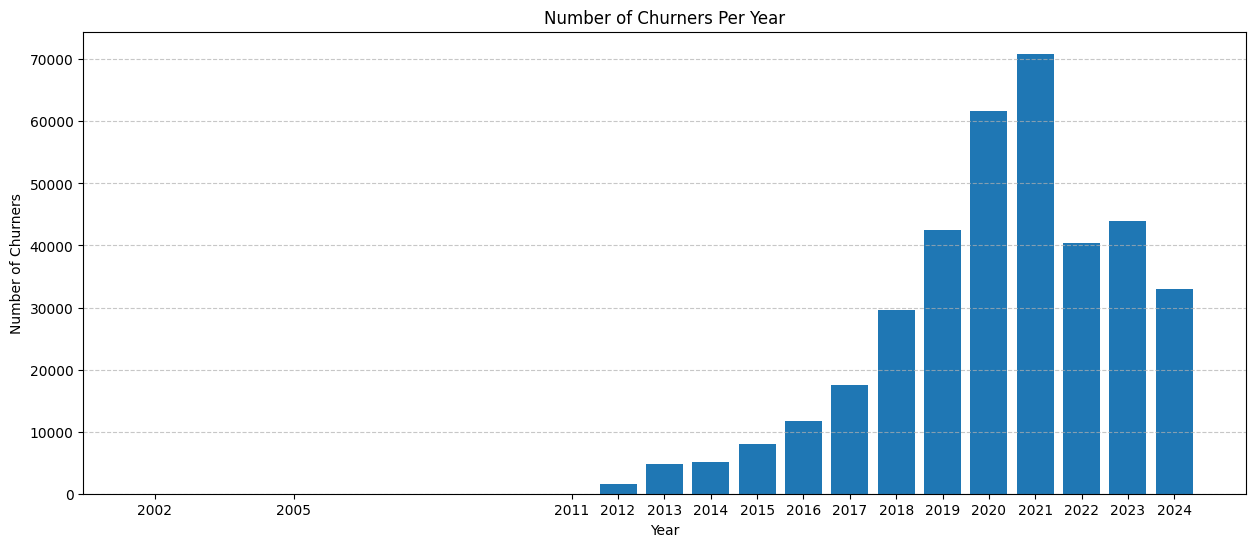

In [0]:
# Count the number of churners for each year in the original dataframe
churned_per_year = result[result['sluttdato'].notna()]
churned_per_year['year'] = churned_per_year['sluttdato'].dt.year
churn_counts = churned_per_year['year'].value_counts().sort_index()

# Plot the churn counts
plt.figure(figsize=(15, 6))
plt.bar(churn_counts.index, churn_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of Churners')
plt.title('Number of Churners Per Year')
plt.xticks(churn_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [0]:
df['sluttdato'].dt.year.astype('Int64')

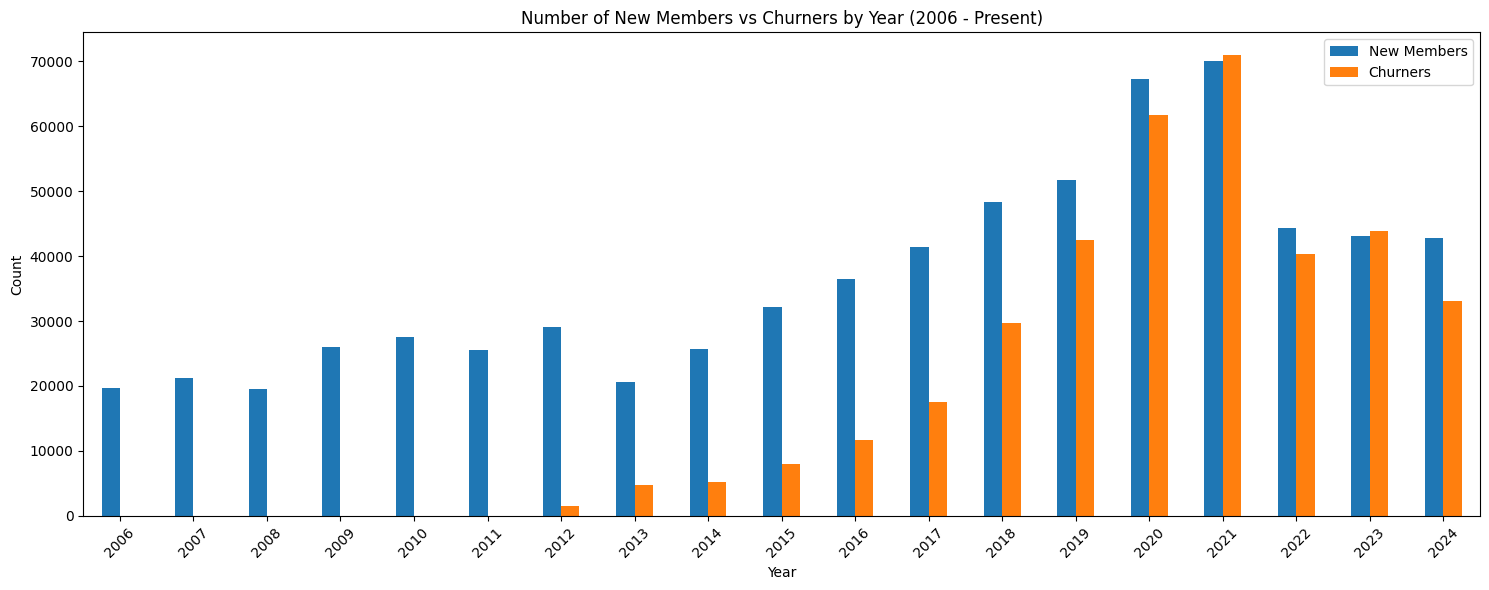

In [0]:
import datetime

# Filter years from 2014 to the current year
current_year = datetime.datetime.now().year
filtered_years = [year for year in years if 2006 <= year <= current_year]
new_members = df['startdato'].dt.year.astype('Int64').value_counts().sort_index()
churners = df['sluttdato'].dt.year.astype('Int64').value_counts().sort_index()

# Combine into a single DataFrame for visualization
data_combined = pd.DataFrame({
    'New Members': new_members.reindex(filtered_years, fill_value=0),
    'Churners': churners.reindex(filtered_years, fill_value=0)
})

# Plot the data
plt.figure(figsize=(15, 6))
data_combined.plot(kind='bar', ax=plt.gca())
plt.title("Number of New Members vs Churners by Year (2006 - Present)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [0]:
result["churn"] = result["sluttdato"].notna()
result = result.drop(columns=["sluttdato", "startdato"])

In [0]:
result.head()

In [0]:
len(result)

741562

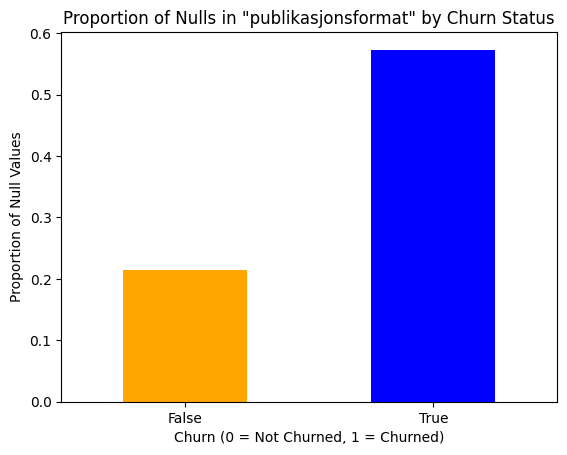

Overall proportion of nulls in publikasjonsformat: 39.39%


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'churn' and 'publikasjonsformat' columns
# 'churn' is 1 for churned users and 0 for active users

newdf = result.copy()
# 1. Create a summary of null and non-null values in publikasjonsformat
newdf['is_null_publikasjonsformat'] = newdf['publikasjonsformat'].isnull()

# Group by churn and check the proportion of nulls
churn_null_summary = newdf.groupby('churn')['is_null_publikasjonsformat'].mean()

# 2. Plot the proportion of nulls for churned and non-churned users
churn_null_summary.plot(kind='bar', color=['orange', 'blue'])
plt.title('Proportion of Nulls in "publikasjonsformat" by Churn Status')
plt.xlabel('Churn (0 = Not Churned, 1 = Churned)')
plt.ylabel('Proportion of Null Values')
plt.xticks(rotation=0)
plt.show()

# 3. Distribution of publikasjonsformat nulls across all data
overall_null_summary = newdf['is_null_publikasjonsformat'].mean()
print(f"Overall proportion of nulls in publikasjonsformat: {overall_null_summary:.2%}")

# 4. Provide insights and recommendations
# Drop it because it skews the data
del newdf
result = result.drop(columns=["publikasjonsformat"])


In [0]:
result.isnull().sum()

In [0]:
import pandas as pd
import numpy as np

# Assuming 'result' is your DataFrame

# Function to impute categorical columns by sampling based on existing distribution
def impute_categorical(df, columns):
    for col in columns:
        # Calculate the frequency of each category
        value_counts = df[col].value_counts(normalize=True)
        # Identify missing values
        mask = df[col].isna()
        n_missing = mask.sum()
        
        if n_missing > 0:
            # Sample values based on the distribution
            sampled_values = np.random.choice(
                value_counts.index,
                size=n_missing,
                p=value_counts.values
            )
            # Fill the missing values
            df.loc[mask, col] = sampled_values

# Function to impute numerical columns by sampling based on existing distribution
def impute_numerical(df, columns, add_noise=False, noise_range=(0, 0)):
    for col in columns:
        # Calculate the frequency of each unique value
        value_counts = df[col].value_counts(normalize=True)
        # Identify missing values
        mask = df[col].isna()
        n_missing = mask.sum()
        
        if n_missing > 0:
            # Sample values based on the distribution
            sampled_values = np.random.choice(
                value_counts.index,
                size=n_missing,
                p=value_counts.values
            )
            
            if add_noise:
                # Add random noise within the specified range
                noise = np.random.randint(noise_range[0], noise_range[1] + 1, size=n_missing)
                sampled_values = sampled_values + noise
            
            # Fill the missing values
            df.loc[mask, col] = sampled_values

# List of categorical columns
categorical_columns = ["gender", "avtale_antall_år", "sentralitetsindex"]

# List of numerical columns
numerical_columns = ["age"]

# Impute categorical columns
impute_categorical(result, categorical_columns)

# Impute numerical columns
# Option 1: Without adding noise
impute_numerical(result, numerical_columns)

# Option 2: With adding noise (e.g., +/- 5 years)
# impute_numerical(result, numerical_columns, add_noise=True, noise_range=(-5, 5))

All columns containing `null` (which will gets dropped)

In [0]:
result.isnull().sum()

In [0]:
result.dropna(inplace=True)
result = result[(result["age"] >= 16) & (result["age"] <= 95)]
result["age"] = result["age"].astype(int)
result = result[(result["avtale_antall_år"] <= result["age"] - 16) & (result["avtale_antall_år"] >= 0)]
result["avtale_antall_år"] = result["avtale_antall_år"].astype(int)
result = result[(result["n_vehic"] >= 0) & (result["n_vehic"] <= 30)]
result["n_vehic"] = result["n_vehic"].astype(int)

All unique column values

In [0]:
for col in result:
    print(result[col].unique())

Churner/Non-churner diff

In [0]:
result["churn"].value_counts()

False    369292
True     366259
Name: churn, dtype: int64

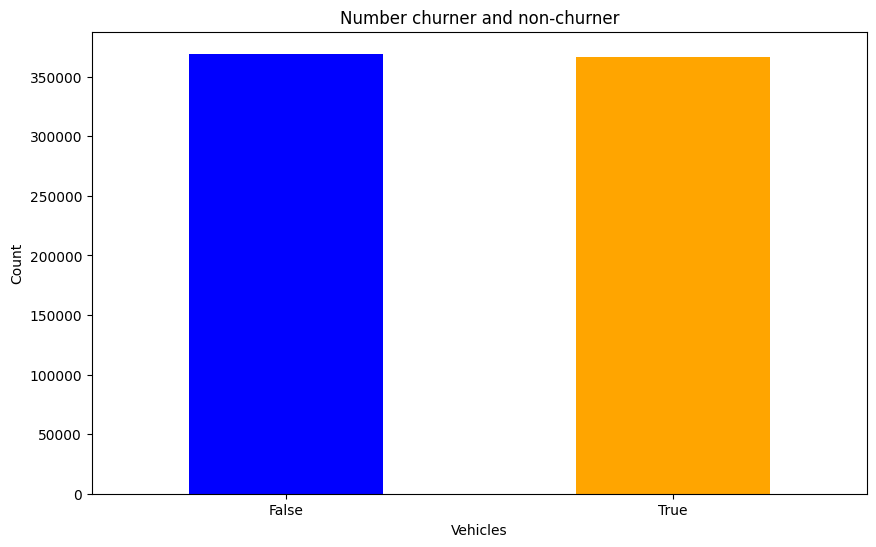

In [0]:
plt.figure(figsize=(10, 6))
result["churn"].value_counts().plot(kind="bar", color=["blue", "orange"])
plt.title("Number churner and non-churner")
plt.xlabel("Vehicles")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

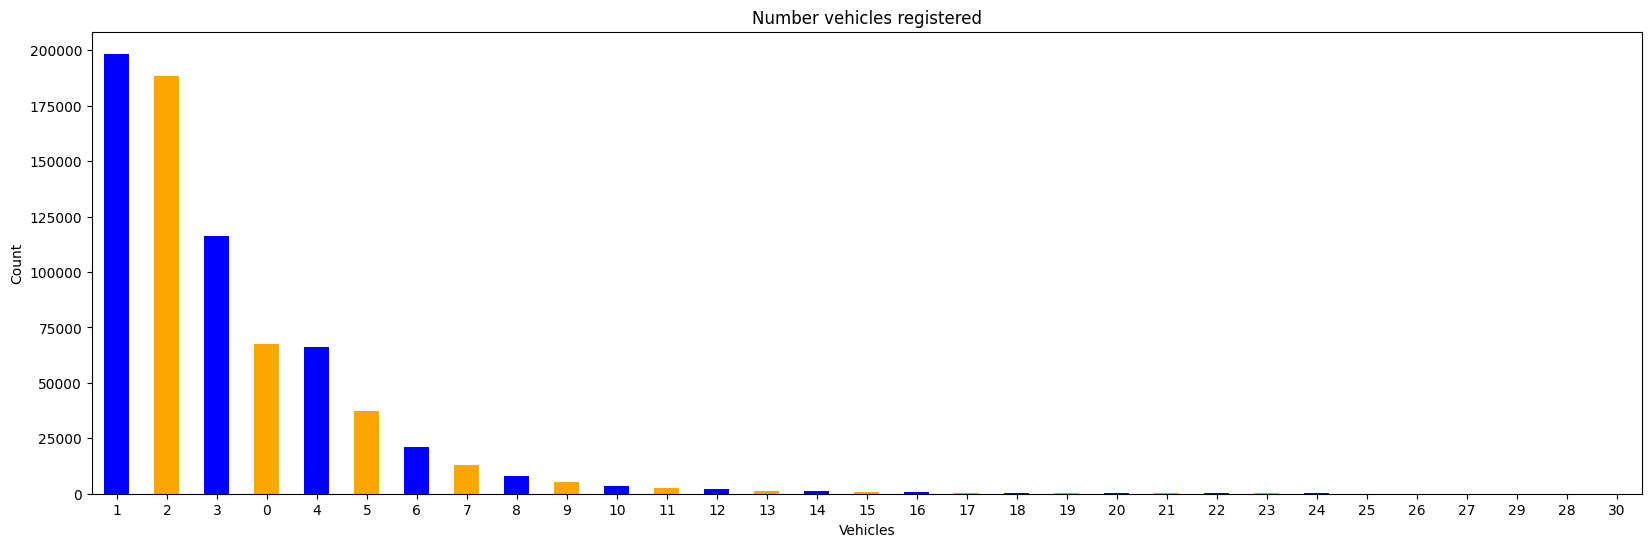

In [0]:
plt.figure(figsize=(20, 6))
result["n_vehic"].value_counts().plot(kind="bar", color=["blue", "orange"])
plt.title("Number vehicles registered")
plt.xlabel("Vehicles")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

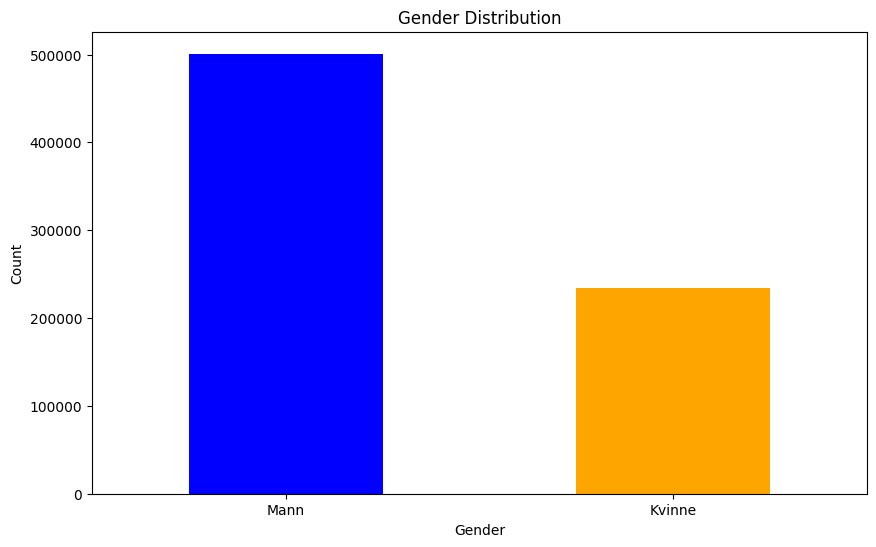

In [0]:
plt.figure(figsize=(10, 6))
result["gender"].value_counts().plot(kind="bar", color=["blue", "orange"])
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

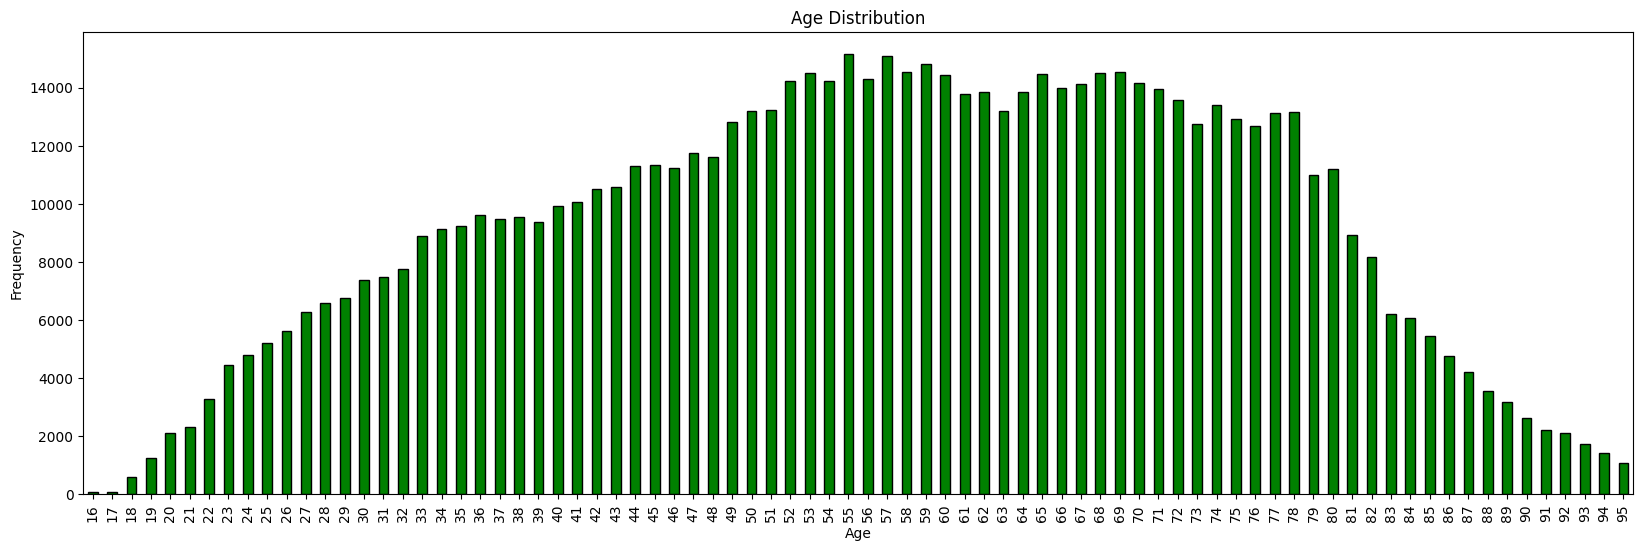

In [0]:
plt.figure(figsize=(20, 6))
result["age"].value_counts().sort_index().plot(kind="bar", color="green", edgecolor="black")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

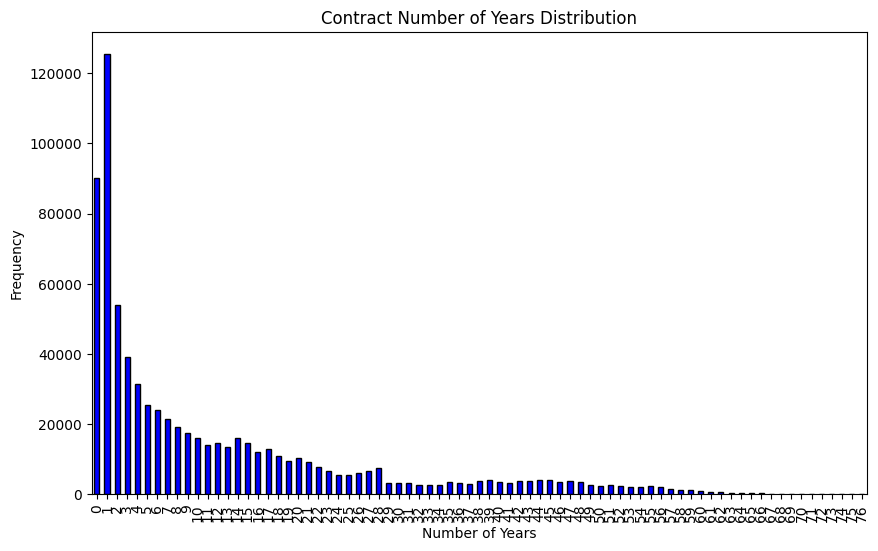

In [0]:
plt.figure(figsize=(10, 6))
result["avtale_antall_år"].value_counts().sort_index().plot(
    kind="bar", color="blue", edgecolor="black"
)
plt.title("Contract Number of Years Distribution")
plt.xlabel("Number of Years")
plt.ylabel("Frequency")
plt.show()

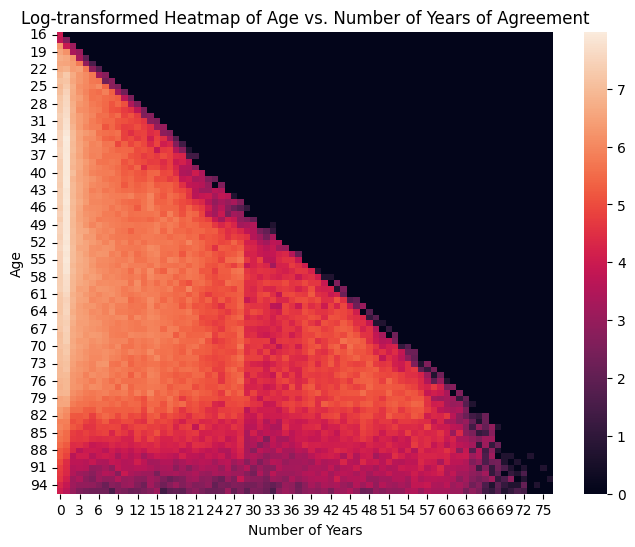

In [0]:
plt.figure(figsize=(8, 6))
heatmap_data = pd.crosstab(result["age"], result["avtale_antall_år"])
sns.heatmap(np.log1p(heatmap_data), cmap="rocket", annot=False, cbar=True)
plt.title("Log-transformed Heatmap of Age vs. Number of Years of Agreement")
plt.xlabel("Number of Years")
plt.ylabel("Age")
plt.show()

# Prediction

In [0]:
df_predict = result
df_predict["gender"] = df_predict["gender"].map({"Mann": 0, "Kvinne": 1})
df_predict["produktnummer"] = df_predict["produktnummer"].map({"2010": 0, "2050": 1})
df_predict["sentralitetsindex"] = df_predict["sentralitetsindex"].astype(int)
df_predict["total_beløp"] = df_predict["total_beløp"].astype(int)
df_predict["produktuttak_count"] = df_predict["produktuttak_count"].astype(int)
# df_predict["publikasjonsformat"] = df_predict["publikasjonsformat"].map({"Papir": 0, "Digital": 1})

In [0]:
df_predict.head()

In [0]:
for col in df_predict:
    print(df_predict[col].unique())

In [0]:
# Create a DataFrame with unique contact_rk and their churn labels
unique_contacts = result[["contact_rk", "churn"]].drop_duplicates()

# Perform stratified train-test split based on churn labels
train_ids, test_ids = train_test_split(
    unique_contacts["contact_rk"], 
    test_size=0.35, 
    random_state=42, 
    stratify=unique_contacts["churn"]
)

# Split the main dataset using the train and test IDs
X_train = result[result["contact_rk"].isin(train_ids)].drop(["contact_rk", "churn"], axis=1)
X_test = result[result["contact_rk"].isin(test_ids)].drop(["contact_rk", "churn"], axis=1)

y_train = result[result["contact_rk"].isin(train_ids)]["churn"]
y_test = result[result["contact_rk"].isin(test_ids)]["churn"]

In [0]:
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Trains the model, makes predictions, and evaluates performance.
    
    Parameters:
    - model: The machine learning model to train and evaluate
    - X_train: Training features
    - X_test: Testing features
    - y_train: Training target
    - y_test: Testing target
    
    Returns:
    - A dictionary containing evaluation metrics and confusion matrix
    """
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = (
        model.predict_proba(X_test)[:, 1]
        if hasattr(model, "predict_proba")
        else None
    )
    
    # Metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    auc_score = (
        roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    )

    # Display results
    print(f"Model: {model.__class__.__name__}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    if auc_score is not None:
        print(f"ROC AUC Score: {auc_score:.4f}")
    else:
        print("ROC AUC Score: Not applicable")
    
    return {"y_pred_proba": y_pred_proba, "auc": auc_score}

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Define a list of models
models = {
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Extra Trees": ExtraTreesClassifier(random_state=42, n_estimators=100),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
    "AdaBoost": AdaBoostClassifier(random_state=42, n_estimators=100),
    "LightGBM": LGBMClassifier(random_state=42),
}

# Dictionary to store results
model_results = {}

# Evaluate each model
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    model_results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)



--- Evaluating CatBoost ---
Model: CatBoostClassifier
Confusion Matrix:
[[ 97776  31935]
 [ 26178 102013]]

Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.75      0.77    129711
        True       0.76      0.80      0.78    128191

    accuracy                           0.77    257902
   macro avg       0.78      0.77      0.77    257902
weighted avg       0.78      0.77      0.77    257902

ROC AUC Score: 0.8600

--- Evaluating Gradient Boosting ---
Model: GradientBoostingClassifier
Confusion Matrix:
[[95773 33938]
 [29842 98349]]

Classification Report:
               precision    recall  f1-score   support

       False       0.76      0.74      0.75    129711
        True       0.74      0.77      0.76    128191

    accuracy                           0.75    257902
   macro avg       0.75      0.75      0.75    257902
weighted avg       0.75      0.75      0.75    257902

ROC AUC Score: 0.8345

--- Evaluating Random 

[00:02:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Model: XGBClassifier
Confusion Matrix:
[[ 97301  32410]
 [ 26491 101700]]

Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.75      0.77    129711
        True       0.76      0.79      0.78    128191

    accuracy                           0.77    257902
   macro avg       0.77      0.77      0.77    257902
weighted avg       0.77      0.77      0.77    257902

ROC AUC Score: 0.8578

--- Evaluating AdaBoost ---
Model: AdaBoostClassifier
Confusion Matrix:
[[94072 35639]
 [35667 92524]]

Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.73      0.73    129711
        True       0.72      0.72      0.72    128191

    accuracy                           0.72    257902
   macro avg       0.72      0.72      0.72    257902
weighted avg       0.72      0.72      0.72    257902

ROC AUC Score: 0.7964

--- Evaluating LightGBM ---
[LightGBM] [Info] Number of positive: 238068,

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Model: LGBMClassifier
Confusion Matrix:
[[ 97883  31828]
 [ 27705 100486]]

Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.75      0.77    129711
        True       0.76      0.78      0.77    128191

    accuracy                           0.77    257902
   macro avg       0.77      0.77      0.77    257902
weighted avg       0.77      0.77      0.77    257902

ROC AUC Score: 0.8546


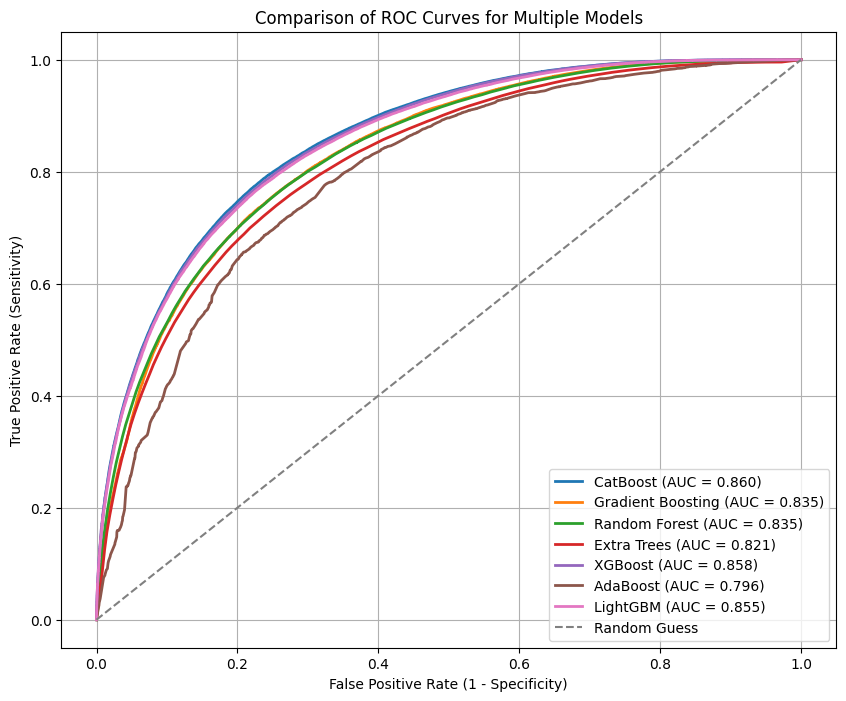

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Plot ROC Curves
plt.figure(figsize=(10, 8))

for name, model in model_results.items():
    y_pred_proba = model["y_pred_proba"]
    
    if y_pred_proba is not None:  # Only plot if predict_proba is available
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = model["auc"]
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", linewidth=2)

# Plot diagonal line for baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

# Add labels and title
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Comparison of ROC Curves for Multiple Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Define a list of models
clf1 = LGBMClassifier(random_state=42)
clf2 = CatBoostClassifier(random_state=42, verbose=0)
clf3 = RandomForestClassifier(random_state=42, n_estimators=100)

eclf1 = VotingClassifier(estimators=[('lgm', clf1), ('cat', clf2), ('rf', clf3)], voting='soft')
evaluate_model(eclf1, X_train, X_test, y_train, y_test)

The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


[LightGBM] [Info] Number of positive: 238068, number of negative: 239581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 477649, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498416 -> initscore=-0.006335
[LightGBM] [Info] Start training from score -0.006335


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


Model: VotingClassifier
Confusion Matrix:
[[ 94755  34956]
 [ 23889 104302]]

Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.73      0.76    129711
        True       0.75      0.81      0.78    128191

    accuracy                           0.77    257902
   macro avg       0.77      0.77      0.77    257902
weighted avg       0.77      0.77      0.77    257902

ROC AUC Score: 0.8582


{'y_pred_proba': array([0.87894399, 0.75729746, 0.9531194 , ..., 0.22287482, 0.56080367,
        0.39090659]),
 'auc': 0.8582150292245689}

In [0]:
from catboost import CatBoostClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

# Initialize Catboost model
cat_model = CatBoostClassifier(random_state=42, verbose=0)

# Fit the model
cat_model.fit(X_train, y_train)

# Make predictions
y_pred_proba = cat_model.predict_proba(X_test)[
    :, 1
]  # Get the probabilities of the positive class
y_pred = cat_model.predict(X_test)

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc}")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Optional: Display a full classification report (precision, recall, F1-score)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

AUC Score: 0.8599613201971845
Accuracy: 0.7746702235732953
Confusion Matrix:
[[ 97776  31935]
 [ 26178 102013]]

Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.75      0.77    129711
        True       0.76      0.80      0.78    128191

    accuracy                           0.77    257902
   macro avg       0.78      0.77      0.77    257902
weighted avg       0.78      0.77      0.77    257902



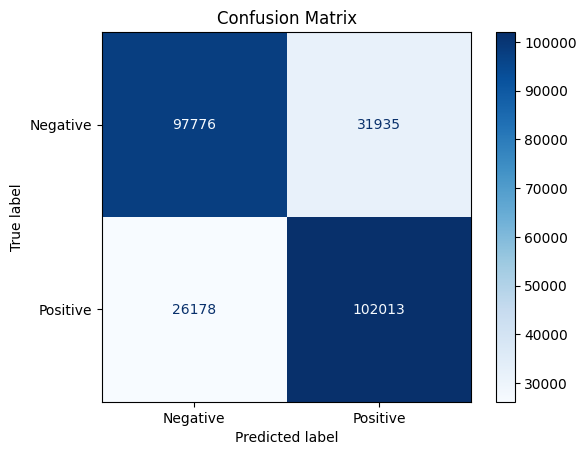

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [0]:
import pandas as pd

# Convert X_test to a DataFrame if it isn't already
X_test_asd = X_test.copy()
X_test_asd['Actual'] = y_test.values  # Add actual values to the DataFrame
X_test_asd['Predicted'] = y_pred  # Add predicted values to the DataFrame

# Filter rows with incorrect predictions
wrong_predictions = X_test_asd[X_test_asd['Actual'] != X_test_asd['Predicted']]

# Analyze which features contribute the most to wrong predictions
# For example, grouping by a specific feature or calculating statistics
wrong_counts = wrong_predictions.groupby(wrong_predictions.columns[:-2].tolist()).size().reset_index(name='WrongCount')

# Sort to identify rows/features triggering the most incorrect predictions
wrong_counts_sorted = wrong_counts.sort_values(by='WrongCount', ascending=False)

# Display the top rows that caused the most wrong predictions
wrong_counts_sorted.head(10)


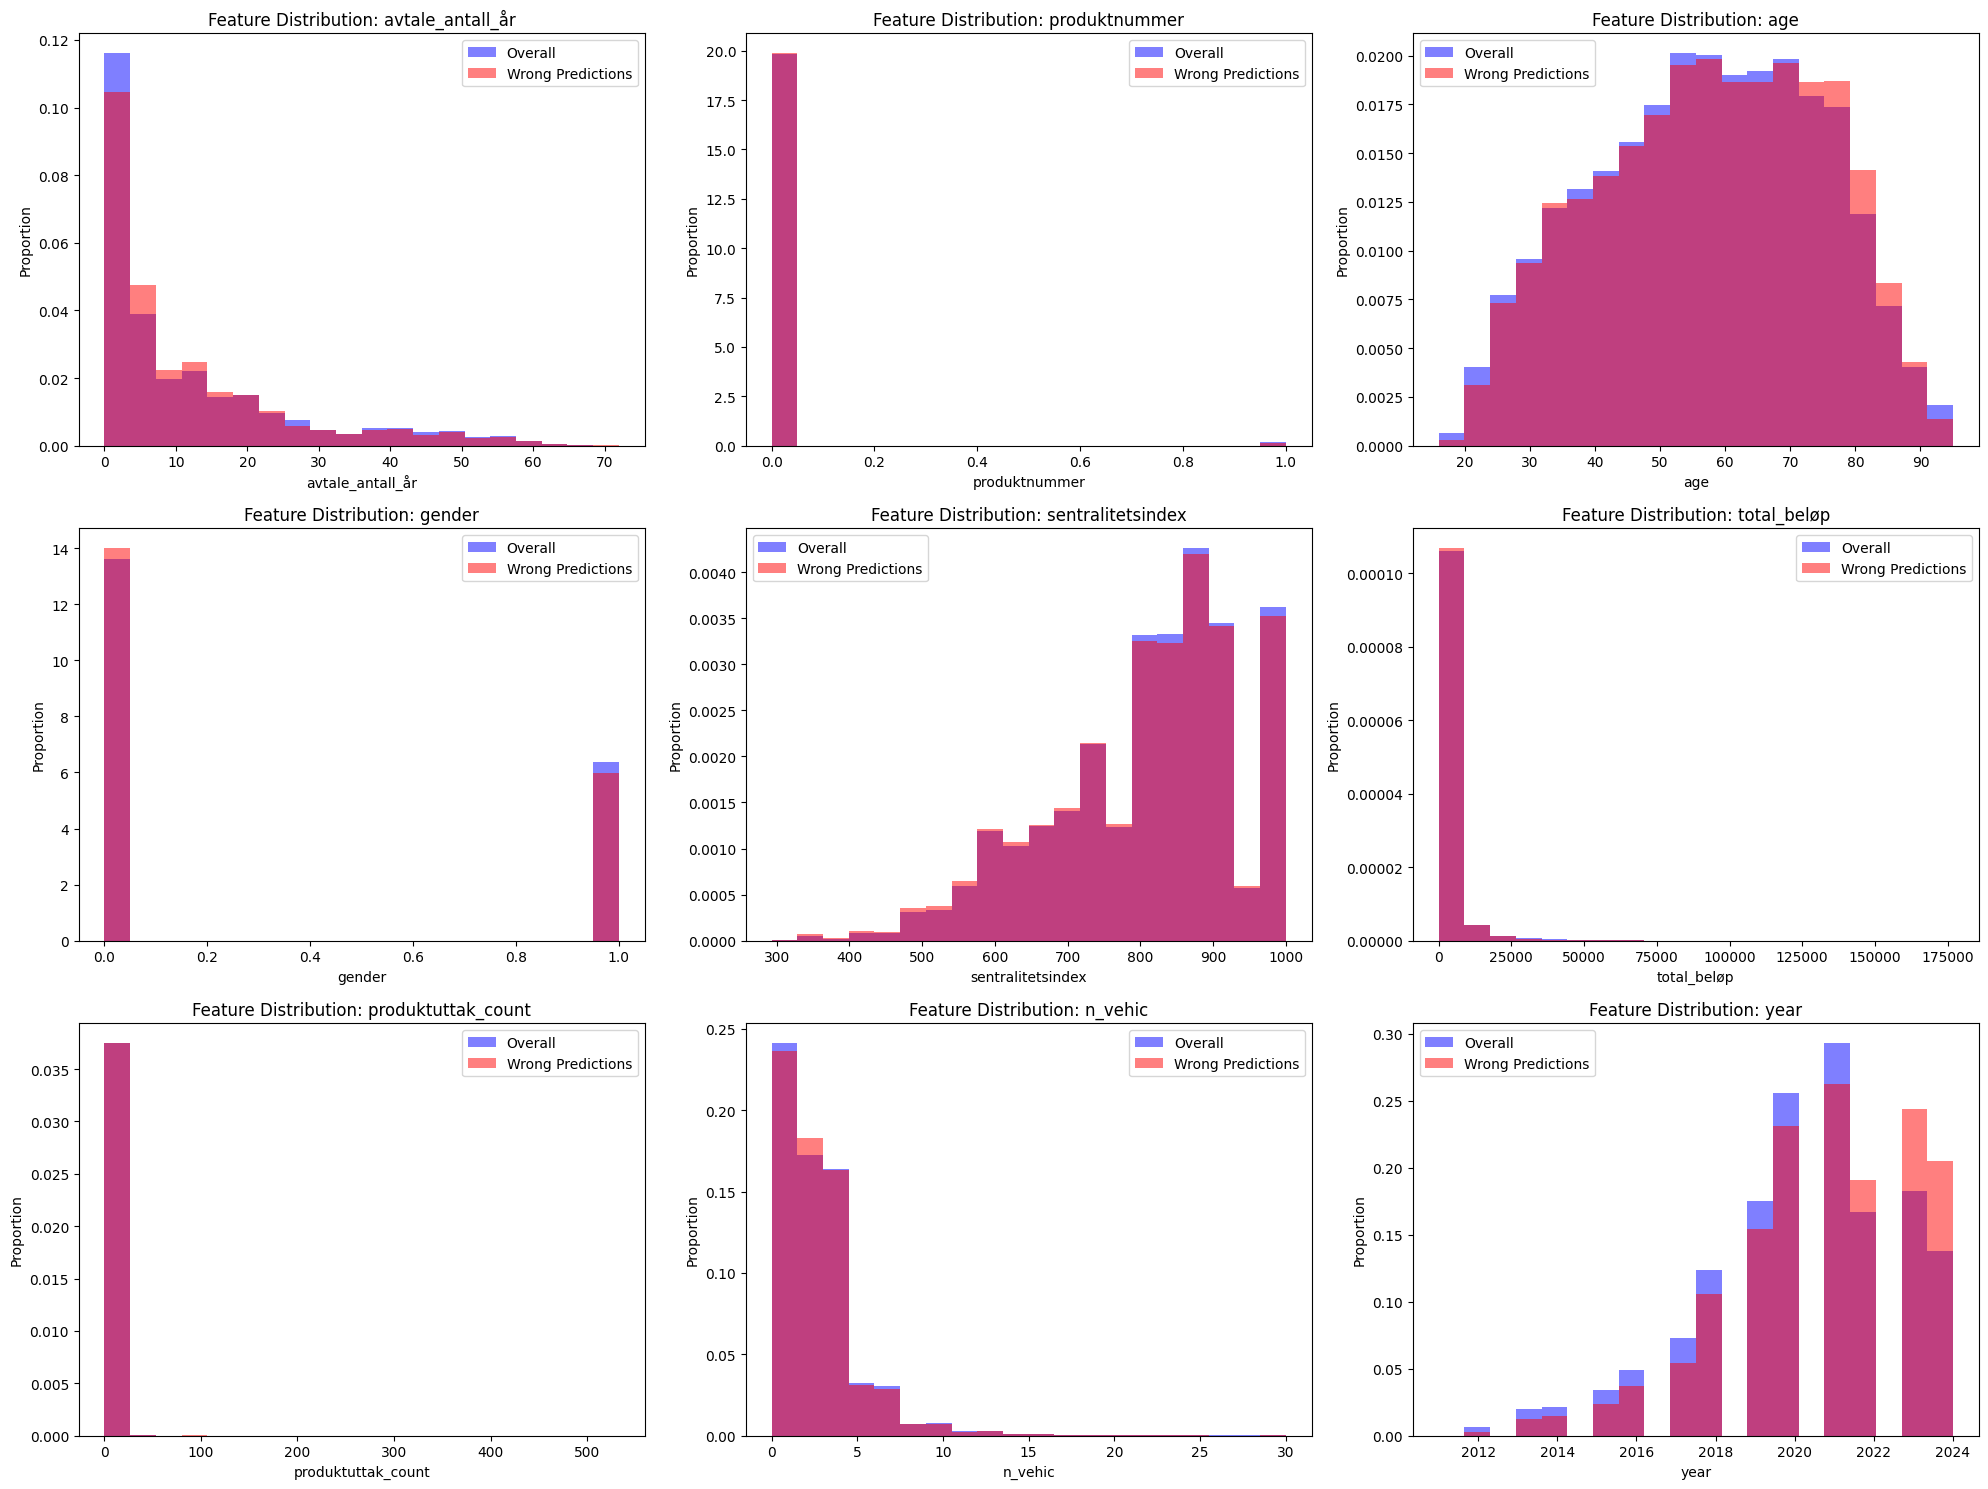

In [0]:
import matplotlib.pyplot as plt

# Select only numeric features for visualization
numeric_features = X_test.select_dtypes(include=['float64', 'int64']).columns

# Determine the number of features
num_features = len(numeric_features)

# Set up the figure size and grid for subplots
fig, axes = plt.subplots(
    nrows=(num_features + 2) // 3, ncols=3, figsize=(20, 5 * ((num_features + 2) // 3))
)
axes = axes.flatten()  # Flatten axes for easy iteration

# Iterate over numeric features and plot histograms
for i, feature in enumerate(numeric_features):
    ax = axes[i]  # Select subplot axis
    
    # Calculate the range of the feature for consistent x-axis limits
    min_value = min(X_test[feature].min(), wrong_predictions[feature].min())
    max_value = max(X_test[feature].max(), wrong_predictions[feature].max())
    
    # Plot histograms with consistent range and normalization
    ax.hist(
        X_test[feature], 
        bins=20, 
        alpha=0.5, 
        label='Overall', 
        color='blue', 
        range=(min_value, max_value), 
        density=True
    )
    ax.hist(
        wrong_predictions[feature], 
        bins=20, 
        alpha=0.5, 
        label='Wrong Predictions', 
        color='red', 
        range=(min_value, max_value), 
        density=True
    )
    
    # Titles and labels
    ax.set_title(f"Feature Distribution: {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel('Proportion')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [0]:
import pandas as pd

# Step 1: Create a copy of X_test and add actual and predicted labels
X_test_analysis = X_test.copy()  # Make a copy to avoid modifying the original
X_test_analysis['Actual'] = y_test.values  # Add the actual churn labels
X_test_analysis['Predicted'] = y_pred  # Add the predicted churn labels
X_test_analysis['Churn_Probability'] = y_pred_proba  # Add the churn probabilities

# Step 2: Filter for false positives (Predicted = 1 but Actual = 0)
false_positives = X_test_analysis[(X_test_analysis['Predicted'] == 1) & (X_test_analysis['Actual'] == 0)]

# Step 3: Save or display the false positives
# Display the first few rows for inspection
false_positives.head()


In [0]:
most_likely = false_positives.sort_values(by='Churn_Probability', ascending=False)
most_likely.head(50)

In [0]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer for the trained XGBoost model
explainer = shap.TreeExplainer(cat_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Get the instance to explain
instance_idx = X_test.index.get_loc(most_likely.index[0])

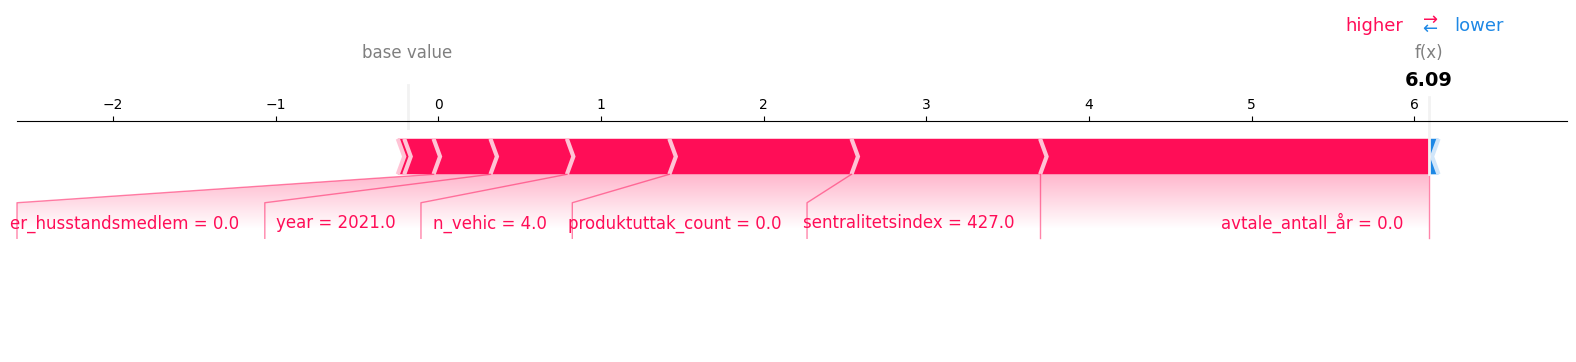

In [0]:
shap.force_plot(
    explainer.expected_value,
    shap_values[instance_idx].round(2),
    X_test.iloc[instance_idx],
    matplotlib=True
)

Visualize the distribution of key features for **false positives** compared to **true negatives** (predicted and actual non-churners) and true positives (predicted and actual churners). This helps identify what makes false positives stand out.

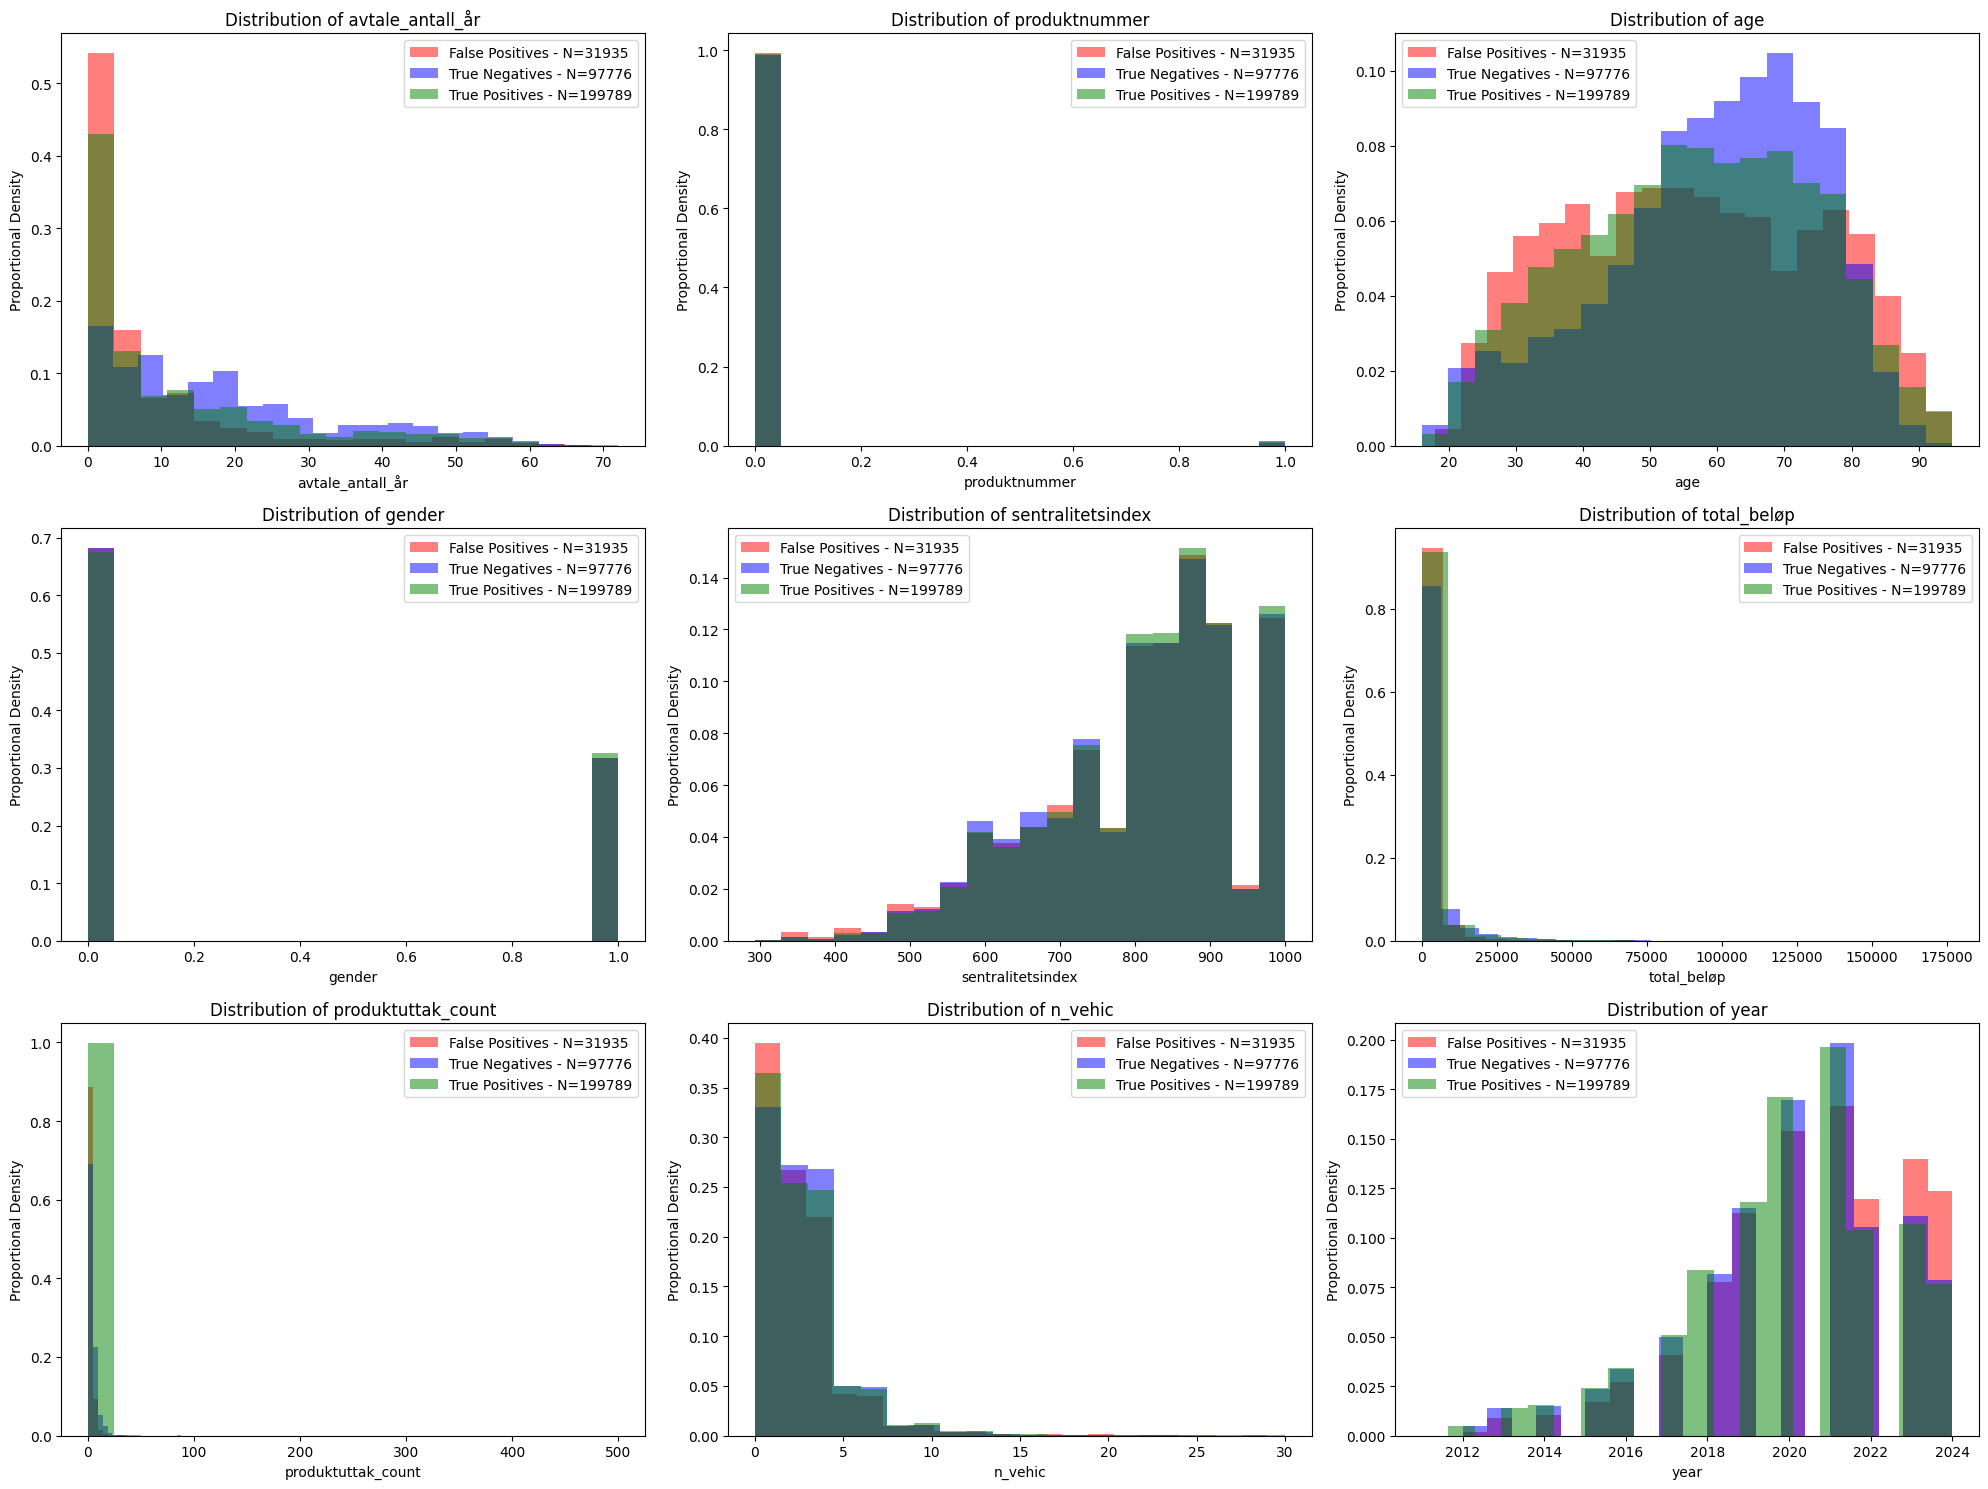

In [0]:
import matplotlib.pyplot as plt

# Group data for comparison
false_positives = X_test_analysis[(X_test_analysis['Predicted'] == 1) & (X_test_analysis['Actual'] == 0)]
true_negatives = X_test_analysis[(X_test_analysis['Predicted'] == 0) & (X_test_analysis['Actual'] == 0)]
true_positives = X_test_analysis[
    (X_test_analysis['Predicted'] == 1) & (X_test_analysis['Actual'] == 1) |
    (X_test_analysis['Predicted'] == 0) & (X_test_analysis['Actual'] == 0)
]

# Select numeric features for visualization
numeric_features = X_test_analysis.select_dtypes(include=['float64', 'int64']).columns.drop(['Churn_Probability'])

# Set up the figure size and grid for subplots
num_features = len(numeric_features)
fig, axes = plt.subplots(
    nrows=(num_features + 2) // 3, ncols=3, figsize=(20, 5 * ((num_features + 2) // 3))
)
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot each feature
for i, feature in enumerate(numeric_features):
    ax = axes[i]  # Select subplot axis
    
    # Plot histograms for False Positives, True Negatives, and True Positives
    ax.hist(
        false_positives[feature],
        bins=20,
        alpha=0.5,
        label=f'False Positives - N={len(false_positives)}',
        color='red',
        weights=[1/len(false_positives)] * len(false_positives),
    )
    ax.hist(
        true_negatives[feature],
        bins=20,
        alpha=0.5,
        label=f'True Negatives - N={len(true_negatives)}',
        color='blue',
        weights=[1/len(true_negatives)] * len(true_negatives),
    )
    ax.hist(
        true_positives[feature],
        bins=20,
        alpha=0.5,
        label=f'True Positives - N={len(true_positives)}',
        color='green',
        weights=[1/len(true_positives)] * len(true_positives),
    )
    
    # Titles and labels
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Proportional Density')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [0]:
# Compare feature means
comparison = pd.DataFrame({
    'False_Positive_Mean': false_positives[numeric_features].mean(),
    'True_Negative_Mean': true_negatives[numeric_features].mean(),
    'True_Positive_Mean': true_positives[numeric_features].mean()
})
comparison['Difference_FP_vs_TN'] = comparison['False_Positive_Mean'] - comparison['True_Negative_Mean']
comparison['Difference_FP_vs_TP'] = comparison['False_Positive_Mean'] - comparison['True_Positive_Mean']

# Sort by the difference to see most distinguishing features
comparison.sort_values(by='Difference_FP_vs_TN', ascending=False)


,False_Positive_Mean,True_Negative_Mean,True_Positive_Mean,Difference_FP_vs_TN,Difference_FP_vs_TP
year,2020.592829,2020.150906,2020.109255,0.441923,0.483574
gender,0.317770,0.318135,0.325303,-0.000365,-0.007533
produktnummer,0.007265,0.011025,0.010211,-0.003760,-0.002946
n_vehic,2.473775,2.569025,2.573615,-0.095250,-0.099840
sentralitetsindex,806.137842,807.507139,811.602766,-1.369296,-5.464923
produktuttak_count,1.860091,3.777358,2.573245,-1.917268,-0.713154
age,56.175638,59.229852,56.964598,-3.054214,-0.788960
avtale_antall_år,8.150023,17.923458,11.636542,-9.773434,-3.486518
total_beløp,1457.755723,3336.383090,2180.273789,-1878.627367,-722.518066


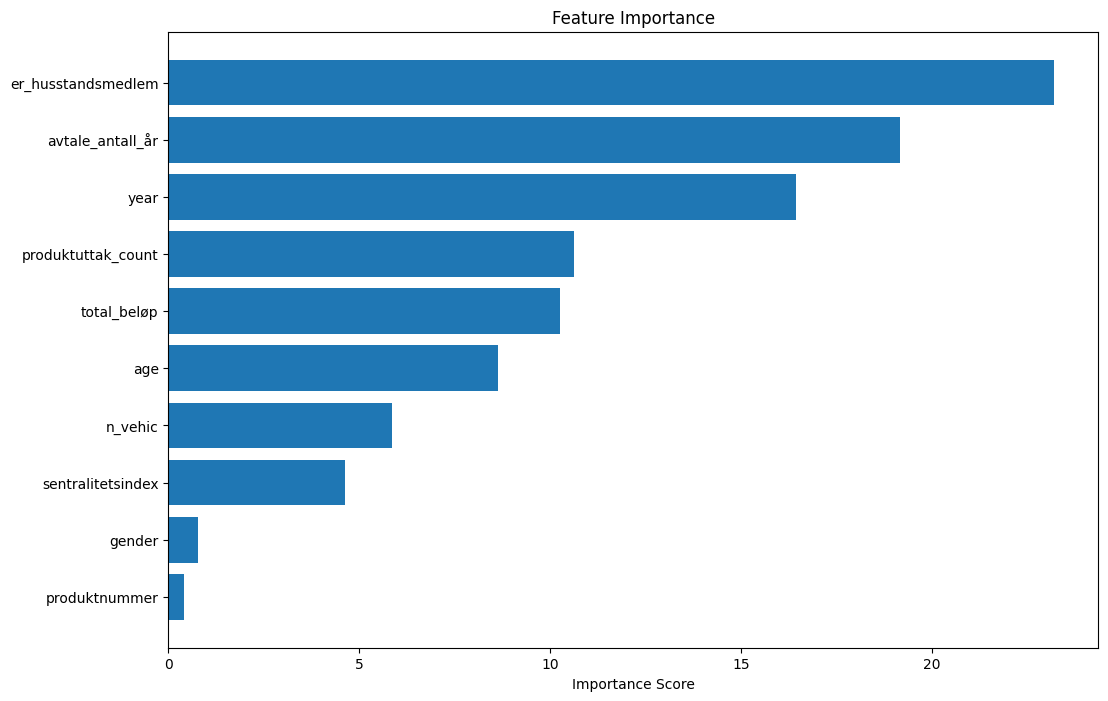

In [0]:
import numpy as np

# Feature importance from the model
feature_importances = cat_model.feature_importances_
features = X_test.columns

# Plot feature importance
plt.figure(figsize=(12, 8))
sorted_idx = np.argsort(feature_importances)
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()


The figure layout has changed to tight


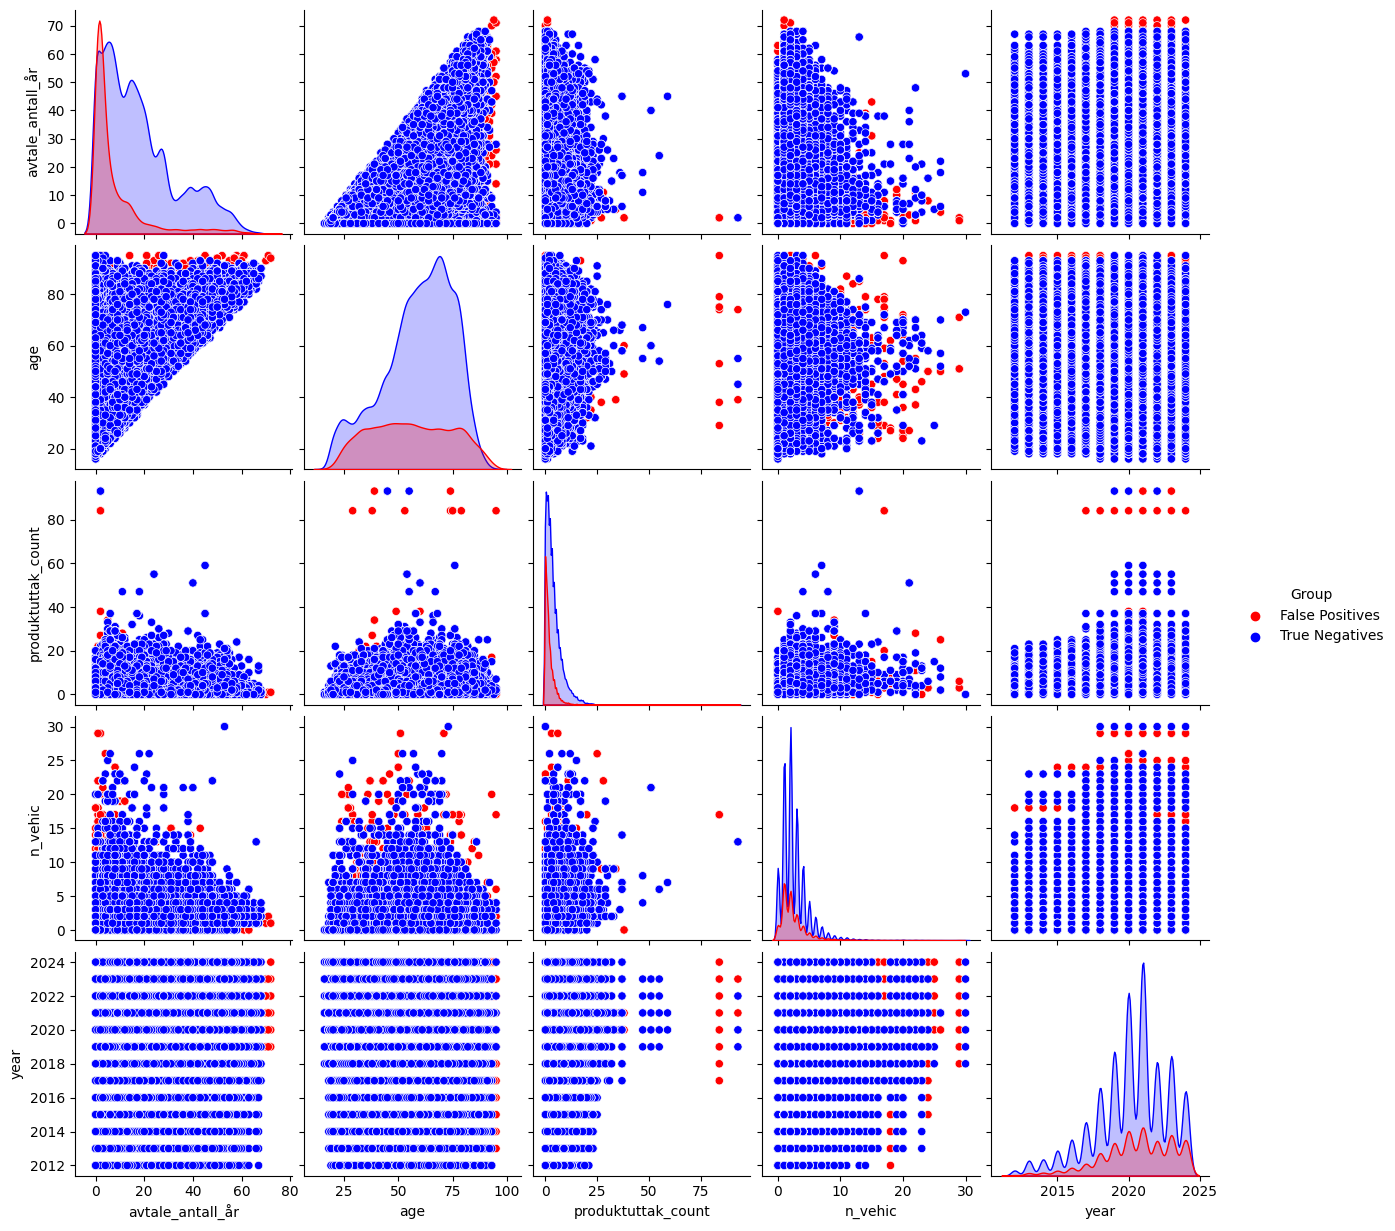

In [0]:
import seaborn as sns

drop = ['produktnummer', 'gender', 'sentralitetsindex', "Actual", "Predicted", "Churn_Probability", "total_beløp"]
# Combine false positives and true negatives for pairplot
comparison_data = pd.concat([
    false_positives.assign(Group='False Positives'),
    true_negatives.assign(Group='True Negatives')
]).drop(columns=(drop))

# Pairplot to compare relationships
sns.pairplot(comparison_data, vars=comparison_data.select_dtypes(include=['float64', 'int64']).columns, hue='Group', diag_kind='kde', palette={'False Positives': 'red', 'True Negatives': 'blue'})
plt.show()


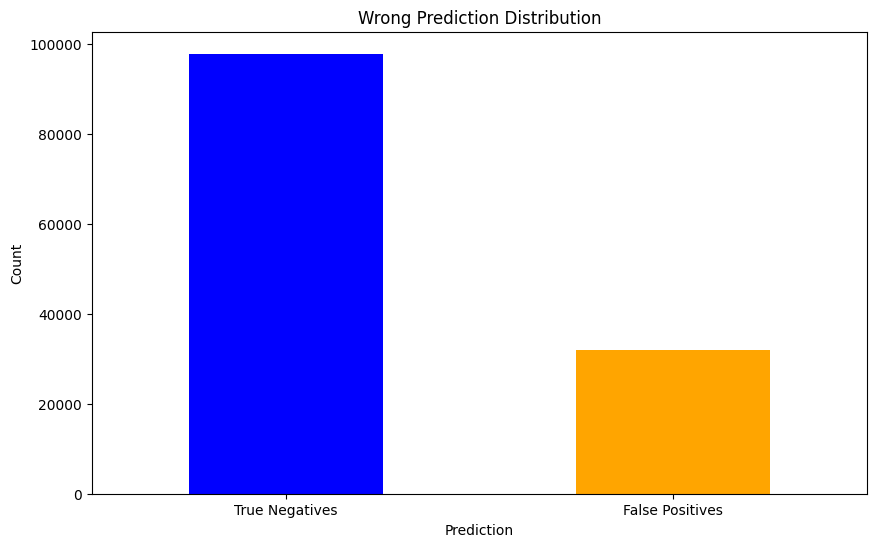

In [0]:
plt.figure(figsize=(10, 6))
comparison_data["Group"].value_counts().plot(kind="bar", color=["blue", "orange"])
plt.title("Wrong Prediction Distribution")
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

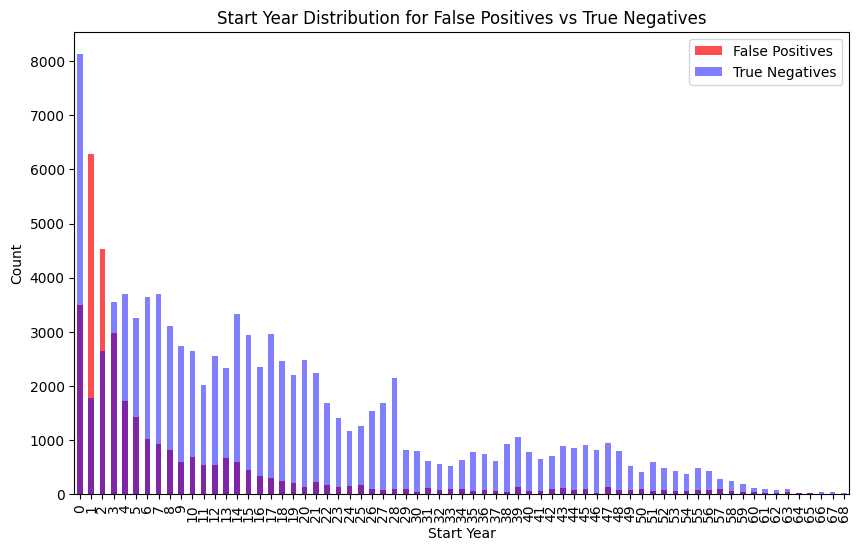

In [0]:
# Convert start date to datetime if not already
# X_test_analysis['start_year'] = pd.to_datetime(X_test_analysis['avtale_antall_år']).dt.year

# Plot temporal trends
plt.figure(figsize=(10, 6))
false_positives['avtale_antall_år'].value_counts().sort_index().plot(kind='bar', color='red', alpha=0.7, label='False Positives')
true_negatives['avtale_antall_år'].value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.5, label='True Negatives')
plt.title('Start Year Distribution for False Positives vs True Negatives')
plt.xlabel('Start Year')
plt.ylabel('Count')
plt.legend()
plt.show()


In [0]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer for the trained XGBoost model
explainer = shap.TreeExplainer(cat_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Get the instance to explain
instance_idx = 0

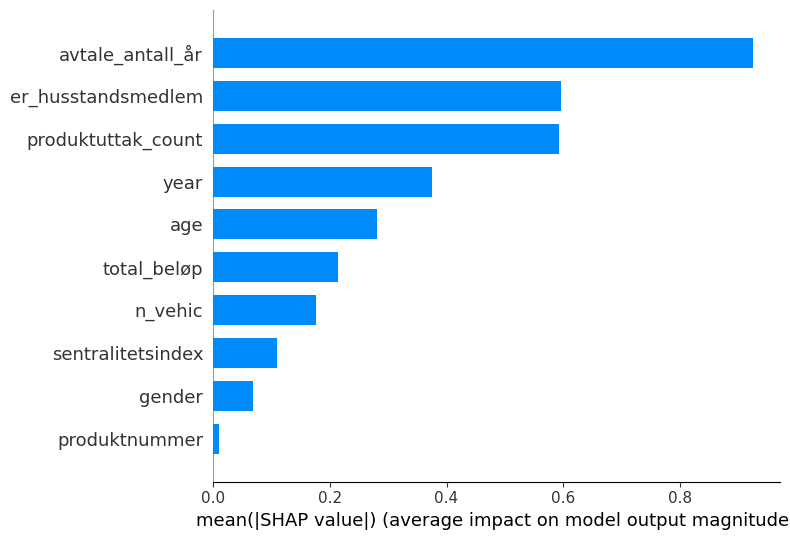

In [0]:
# Summary Plot: Overall feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

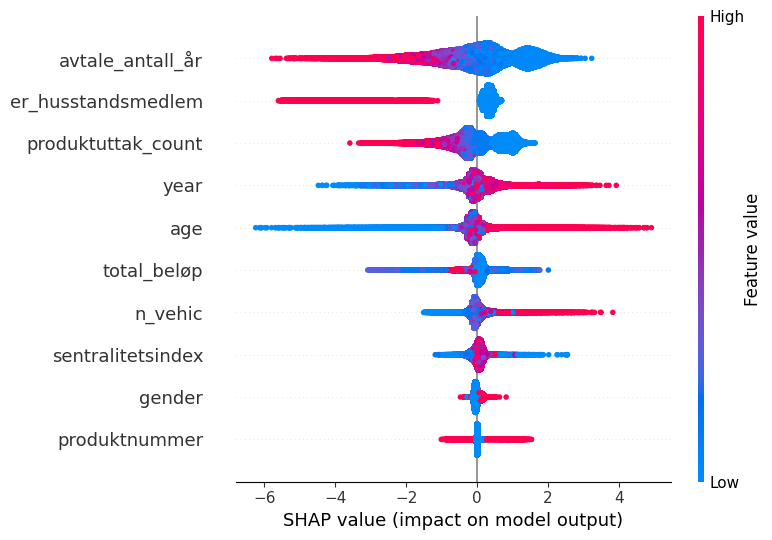

In [0]:
# Detailed Summary Plot: Overview of feature contributions
shap.summary_plot(shap_values, X_test)

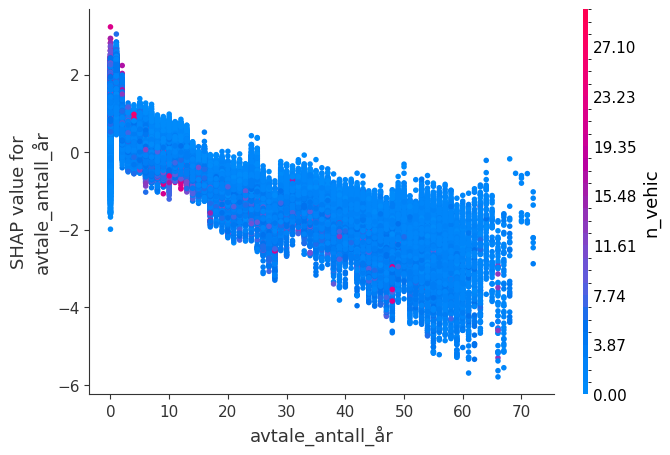

In [0]:
# Dependence Plot: Analyze the interaction of a specific feature
shap.dependence_plot('avtale_antall_år', shap_values, X_test)

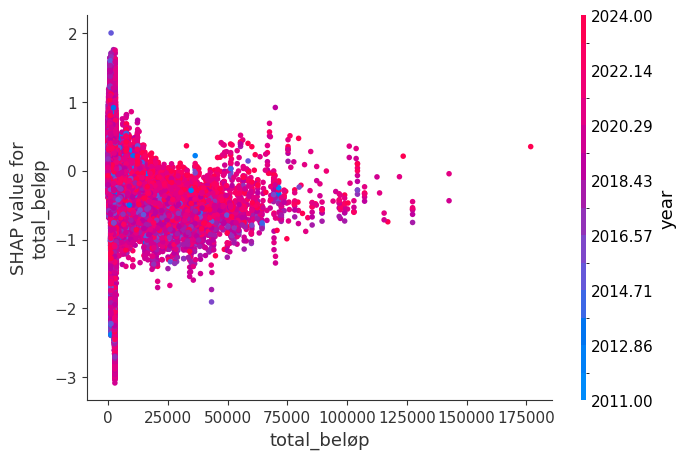

In [0]:
# Dependence Plot: Analyze the interaction of a specific feature
shap.dependence_plot('total_beløp', shap_values, X_test)

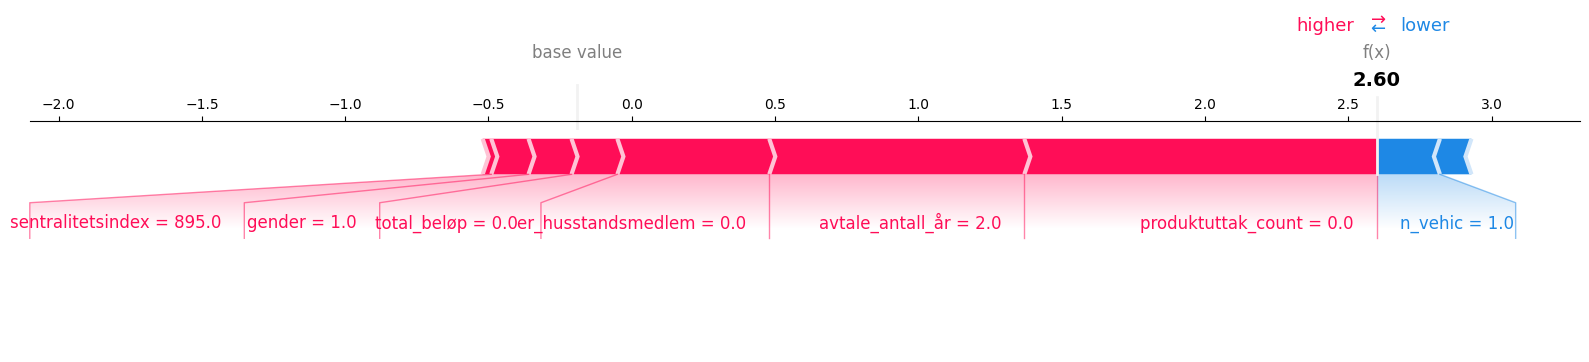

In [0]:
shap.force_plot(
    explainer.expected_value,
    shap_values[instance_idx].round(2),
    X_test.iloc[instance_idx],
    matplotlib=True
)

In [0]:
idx_df = pd.DataFrame([X_test.iloc[instance_idx]])
idx_df['churn'] = y_test.iloc[instance_idx]

idx_df

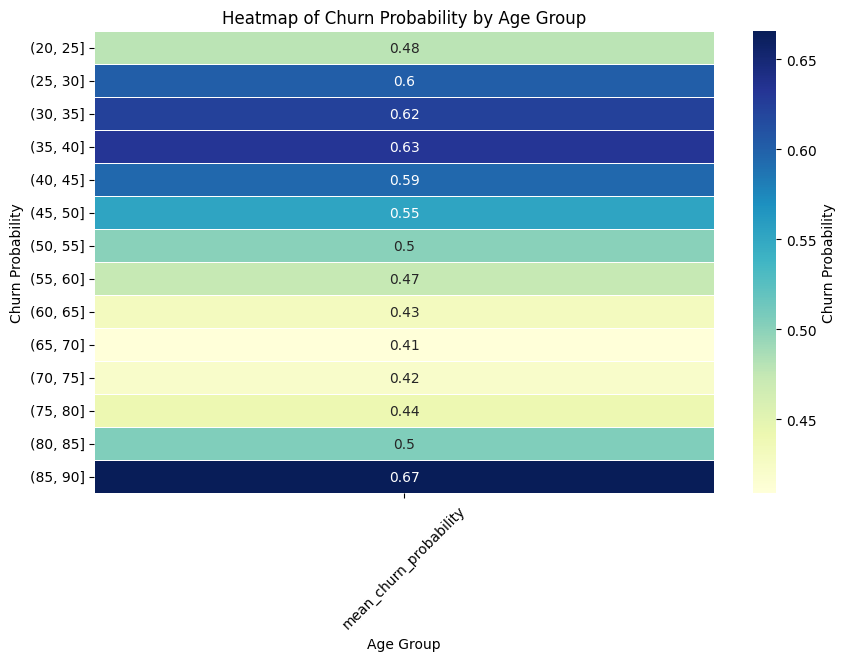

In [0]:
df_churn_prob = pd.DataFrame(
    {
        "age": X_test["age"],  # Age column from X_test
        "churn_probability": y_pred_proba,  # Churn probabilities from XGBoost
    }
)

# Bin ages into 5-year intervals (you can adjust the bin size as needed)
df_churn_prob["age_bin"] = pd.cut(
    df_churn_prob["age"], bins=np.arange(20, 91, 5)
)  # 5-year bins from 20 to 90

# Calculate the mean churn probability for each age group
df_heatmap = (
    df_churn_prob.groupby("age_bin")
    .agg(mean_churn_probability=("churn_probability", "mean"))
    .reset_index()
)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    df_heatmap.pivot_table(index="age_bin", values="mean_churn_probability"),
    annot=True,
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Churn Probability"},
)
plt.title("Heatmap of Churn Probability by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Churn Probability")
plt.xticks(rotation=45)
plt.show()